# Анализ бизнес-показателей

Для приложения Procrastinate Pro+ необходимо разобраться в причинах убытков и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях;
- выгрузка их покупок за этот период;
- рекламные расходы.

Нам предстоит изучить:

- откуда приходят пользователи и какими устройствами они пользуются;
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент;
- когда расходы на привлечение клиента окупаются;
- какие факторы мешают привлечению клиентов.

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as st
from datetime import datetime, timedelta

In [2]:
# Указываем базовые настройки 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set()
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

In [3]:
# Указываем путь к файлу
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except: 
    costs = pd.read_csv('C:/Users/Boris/datasets/costs_info_short.csv')
    orders = pd.read_csv('C:/Users/Boris/datasets/orders_info_short.csv')
    visits = pd.read_csv('C:/Users/Boris/datasets/visits_info_short.csv')

В вашем распоряжении три датасета:

In [4]:
visits.head(5)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


**visits** хранит лог сервера с информацией о посещениях сайта

Структура:

- **User Id** — уникальный идентификатор пользователя,
- **Region** — страна пользователя,
- **Device** — тип устройства пользователя,
- **Channel** — идентификатор источника перехода,
- **Session Start** — дата и время начала сессии,
- **Session End** — дата и время окончания сессии.

In [5]:
orders.head(5)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


**orders** — хранит информацию о заказах

Структура:

- **User Id** — уникальный идентификатор пользователя,
- **Event Dt** — дата и время покупки,
- **Revenue** — сумма заказа.

In [6]:
costs.head(5)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


**costs** — хранит информацию о расходах на рекламу

Структура costs_info_short.csv:

- **d**t — дата проведения рекламной кампании,
- **Channel** — идентификатор рекламного источника,
- **costs** — расходы на эту кампанию.

## Предобработка данных

Перед использование данных, необходимо привести их в рабочее состояни: проверить дубликаты, пропуски в таблице, соответствие колличества строк, приведение к нужному типу данных. Также, для удобства, приведу названия столбцов к нижнему регистру.

In [7]:
# Приводим все данные к нижнему регистру
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()
# Для удобства сразу переименуем некоторые столбцы
visits = visits.rename(columns={'session start': 'session_start', 'session end': 'session_end', 'user id': 'user_id'})
orders = orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'})

In [8]:
# Приводим необходимые столбцы к нужному формату
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Для удобства мы привели все названия столбцов к нижнему регистру, также, привели некоторые столбцы к нужному формату данных

In [9]:
# Проверяем наличие пропусков в наборе данных visits
print('Проверяем сумму пропусков по столбцам в данных visits')
visits.isna().sum()

Проверяем сумму пропусков по столбцам в данных visits


user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [10]:
# Проверяем наличие пропусков в наборе данных orders
print('Проверяем сумму пропусков по столбцам в данных orders')
orders.isna().sum()

Проверяем сумму пропусков по столбцам в данных orders


user_id     0
event_dt    0
revenue     0
dtype: int64

In [11]:
# Проверяем наличие пропусков в наборе данных costs
print('Проверяем сумму пропусков по столбцам в данных costs')
costs.isna().sum()

Проверяем сумму пропусков по столбцам в данных costs


dt         0
channel    0
costs      0
dtype: int64

Провели проверку данных на колличество пропусков, которых не оказалось

In [12]:
print('Колличество дубликатов в данных visits:', visits.duplicated().sum())
print('Колличество дубликатов в данных orders:', orders.duplicated().sum())
print('Колличество дубликатов в данных costs:', costs.duplicated().sum())

Колличество дубликатов в данных visits: 0
Колличество дубликатов в данных orders: 0
Колличество дубликатов в данных costs: 0


В имеющихся данных нет дубликатов.

Таким образом, предварительная обработка данных была выполнена. Все данные были сохранены.

## Вспомогательные функции

Зададим вспомогательные функции, которые пригодятся для дальнейшей работы:

***get_profiles*** - функция для создания пользовательских профилей, с параметрами посещений сайта, заказов и цен на рекламную компанию.

In [13]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):
    '''Функция создания пользовательских профилей'''
    # находим параметры первых посещений
    profiles = (
        sessions
        .sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles
        .groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
                        ad_costs[['dt', 'channel', 'acquisition_cost']],
                        on=['dt', 'channel'],
                        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

***get_retention*** - функция для расчета удержания, показывает сколько пользователей воспользовалось услугой в последующий, заданный, период.

In [14]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    '''Функция для расчета удержания'''
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        '''Вспомогательная функция для группировки таблицы по признакам'''
        result = df.pivot_table(
                    index=dims, 
                    columns='lifetime', 
                    values='user_id', 
                    aggfunc='nunique',
        )
        cohort_sizes = (
            df
            .groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

***get_conversion*** - функция для расчета конверсии по продажам с сайта. 

In [15]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    
    '''Функция расчета конверсии'''
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases
        .sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        '''Функция группировки таблицы по признакам'''
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

***get_ltv*** - функия для расчета LTV и ROI. **LTV** - пожизненная ценность клиента. **ROI** окупаемость инвестиций. 

In [16]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    '''Функция расчета LTV и ROI'''
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # что мы здесь делаем???
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функции для вычисления необходимых параметров заданы, далее задаем функции для построения графиков

In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    '''Функция сглаживания фрейма'''
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    '''Функция визуализации удержания'''
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    '''Функция визуализации конверсии'''
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [20]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    '''Функция визуализации LTV и ROI'''
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Для проведения исследовательского анализа данных необходимо:

- Составить профили пользователей. Определить минимальную и максимальную даты привлечения пользователей.
- Выяснить, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построить таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнать, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построить таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучить рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построить таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

### Пользовательские профили

С помощью функции ***get_profiles*** получим данные по профилям пользователей.

In [21]:
# Применяем функцию
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


In [22]:
# Расчитываем дану начала и окончания наблюдений
print('Дата начала наблюдений:','\t', profiles['dt'].min())
print('Дата окончания наблюдений:','\t', profiles['dt'].max())

Дата начала наблюдений: 	 2019-05-01
Дата окончания наблюдений: 	 2019-10-27


In [23]:
# Задаем переменные observation_date и горизонт планирования по условиям
observation_date = profiles['dt'].max()
horizon_days = 14

По полученным данным видно, что начало наблюдей пришлось на 1 мая 2019 года, а окончание наблюдений на 27 октября 2019 года. Поэтому мы сразу установим в качестве ***observation_date*** самую конечную дату наблюдений. При этом по условиям горизонт наблюдения будет равен 14 дням. 

### Определение колличества пользователей по <u>странам</u>

Далее нам необходимо сделать расчет распределения платящих и неплатящих пользователей по странам:

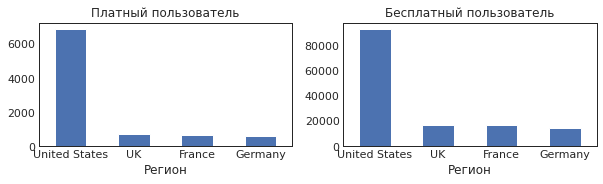

,free_users,payed_users,all_users,"conversion, %"
region,,,,
United States,93100,6902,100002,6.90
UK,16875,700,17575,3.98
France,16787,663,17450,3.80
Germany,14365,616,14981,4.11


In [24]:
# Делаем расчет платящих пользователей в зависимости от региона
payer_users_region = (
    profiles
        .query('payer == True')
        .pivot_table(index = 'region',
                     values = 'user_id',
                     aggfunc= 'nunique') 
        .sort_values('user_id', ascending=False)
)

# Делаем расчет неплатящих пользователей в зависимости от региона
free_users_region = (
    profiles
        .query('payer == False')
        .pivot_table(index = 'region',
                     values = 'user_id',
                     aggfunc= 'nunique') 
        .sort_values('user_id', ascending=False)
)

# Строим графики по полученным данным в зависимости от региона
plt.figure(figsize=(10, 5))
payer_users_region.plot(kind='bar', 
                 ax=plt.subplot(2,2,1), 
                 title='Платный пользователь',
                 legend='')
plt.xticks(rotation=0)
plt.xlabel('Регион')
free_users_region.plot(kind='bar', 
                ax=plt.subplot(2,2,2),
                title='Бесплатный пользователь',
                legend='')
plt.xticks(rotation=0)
plt.xlabel('Регион')

# Делаем таблицу 
users_region = (
    free_users_region
        .merge(payer_users_region, on='region')
        .rename(columns={'user_id_x': 'free_users', 'user_id_y': 'payed_users'})
)
users_region['all_users'] = users_region['free_users'] + users_region['payed_users']
users_region['conversion, %'] = (users_region['payed_users'] / (users_region['payed_users'] + users_region['free_users'])) * 100
plt.show()
users_region

По полученным данным видно, что больше всего пользователей, как платных, так и бесплатных привлечено из US. Однако, несмотря на то, что в Германии было меньше привлечено пользователей, тем не менее, конверсия в Германии несколько выше чем в UK или Франции.

### Определение колличества пользователей по <u>устройствам</u>

Смотрим колличество пользователей в зависимости от устройства, на котором был заказ: 

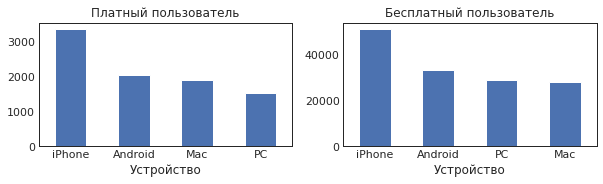

,free_users,payed_users,all_users,"conversion, %"
device,,,,
iPhone,51097,3382,54479,6.21
Android,32982,2050,35032,5.85
PC,28918,1537,30455,5.05
Mac,28130,1912,30042,6.36


In [25]:
# Делаем расчет платящих пользователей в зависимости от устройства
payer_users_device = (
    profiles
        .query('payer == True')
        .pivot_table(index = 'device',
                     values = 'user_id',
                     aggfunc= 'nunique') 
        .sort_values('user_id', ascending=False)
)

# Делаем расчет неплатящих пользователей в зависимости от устройства
free_users_device = (
    profiles
        .query('payer == False')
        .pivot_table(index = 'device',
                     values = 'user_id',
                     aggfunc= 'nunique') 
        .sort_values('user_id', ascending=False)
)

# Строим графики по полученным данным
plt.figure(figsize=(10, 5))
payer_users_device.plot(kind='bar', 
                 ax=plt.subplot(2,2,1), 
                 title='Платный пользователь',
                 legend='')
plt.xticks(rotation=0)
plt.xlabel('Устройство')
free_users_device.plot(kind='bar', 
                ax=plt.subplot(2,2,2),
                title='Бесплатный пользователь',
                legend='')
plt.xticks(rotation=0)
plt.xlabel('Устройство')

# Делаем таблицу с данными
users_device = (
    free_users_device
        .merge(payer_users_device, on='device')
        .rename(columns={'user_id_x': 'free_users', 'user_id_y': 'payed_users'})
)
users_device['all_users'] = users_device['free_users'] + users_device['payed_users']
users_device['conversion, %'] = (users_device['payed_users'] / (users_device['payed_users'] + users_device['free_users'])) * 100
plt.show()
users_device.sort_values(by='free_users', ascending=False)

По полученным данным видно, что больше всего пользователей привлечено с устрова iPhone, он же лидирует по колличеству платных пользователей, а вот больше всего конверсия в покупателей происходит у пользователей с устройств Mac. 

### Определение колличества пользователей по каналам <u>привлечения</u>

Необходимо посчитать колличество пользователей по каналам привлечения: 

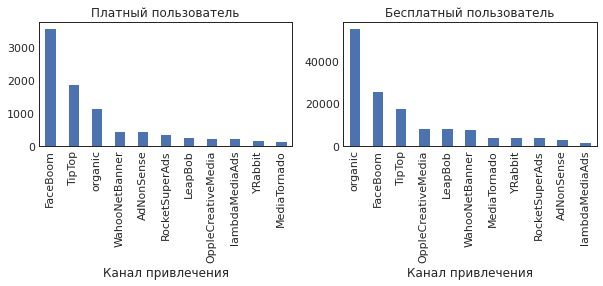

,free_users,payed_users,all_users,"conversion, %"
channel,,,,
organic,55279,1160,56439,2.06
FaceBoom,25587,3557,29144,12.20
TipTop,17683,1878,19561,9.60
OppleCreativeMedia,8372,233,8605,2.71
LeapBob,8291,262,8553,3.06
WahooNetBanner,8100,453,8553,5.30
MediaTornado,4208,156,4364,3.57
YRabbit,4147,165,4312,3.83
RocketSuperAds,4096,352,4448,7.91


In [26]:
# Делаем расчет платящих пользователей в зависимости от каналов привлечения
payer_users_channel = (
    profiles
        .query('payer == True')
        .pivot_table(index = 'channel',
                     values = 'user_id',
                     aggfunc= 'nunique') 
        .sort_values('user_id', ascending=False)
)

# Делаем расчет неплатящих пользователей в зависимости от каналов привлечения
free_users_channel = (
    profiles
        .query('payer == False')
        .pivot_table(index = 'channel',
                     values = 'user_id',
                     aggfunc= 'nunique') 
        .sort_values('user_id', ascending=False)
)

# Строим графики по полученным данным
plt.figure(figsize=(10, 5))
payer_users_channel.plot(kind='bar', 
                 ax=plt.subplot(2,2,1), 
                 title='Платный пользователь',
                 legend='')
plt.xlabel('Канал привлечения')
free_users_channel.plot(kind='bar', 
                ax=plt.subplot(2,2,2),
                title='Бесплатный пользователь',
                legend='')
plt.xlabel('Канал привлечения')

# Строим таблицу, с данными и конверсией
users_channel = (
    free_users_channel
        .merge(payer_users_channel, on='channel')
        .rename(columns={'user_id_x': 'free_users', 'user_id_y': 'payed_users'})
)
users_channel['all_users'] = users_channel['free_users'] + users_channel['payed_users']
users_channel['conversion, %'] = (users_channel['payed_users'] / (users_channel['payed_users'] + users_channel['free_users'])) * 100
plt.show()
users_channel.sort_values(by='free_users', ascending=False)

По полученным данным видно, что больше всего пользователей приходится на органический переход, тем не менее большую конверсию приносят переходы с платформы FaceBoom, далее идут AdNonSense и lambdaMediaAds.

### Выводы по главе

Были сформированы пользовательские профили. Определены даты начала и конца наблюдений. 

***Определены колличества пользователей по странам:*** 
- Больше всего пользователей из US, также у этих пользователей самая большая конверсия 6.9%

***Определены колличества пользователей по устройствам:***
- Больше всего пользователей приходят с iPhone, далее идут Android, PC и Mac;
- При расчете конверсии стало видно, что платных пользователей с Mac больше чем c PC. 

***Определены колличества пользователей по каналам привлечения:*** 
- Больше всего приходит с органических переходов, далее идут TipTop и FaceBoom;
- Большей конверсией обладают пользователи пришедшие с FaceBoom, далее TipTop и заключает тройку лидеров пользователи с органическими переходами

## Маркетинговые исследования

Для проведения маркетинговых исследований необходимо:

- Посчитать общую сумму расходов на маркетинг.
- Выяснить, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построить визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнать, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

### Определение общей суммы расходов на маркетинг

Для определения общей суммы расходов суммируем все данные в столбце **costs**.

In [27]:
print('Общая сумма расходов на маркетинг:','\t' , round(costs['costs'].sum(), 2))

Общая сумма расходов на маркетинг: 	 105497.3


Таким образом, общая сумма расходов составила 105497.3 условных единицы.

### Распределение трат по рекламным источникам

Определим сколько было затрачено на рекламу в разных источниках

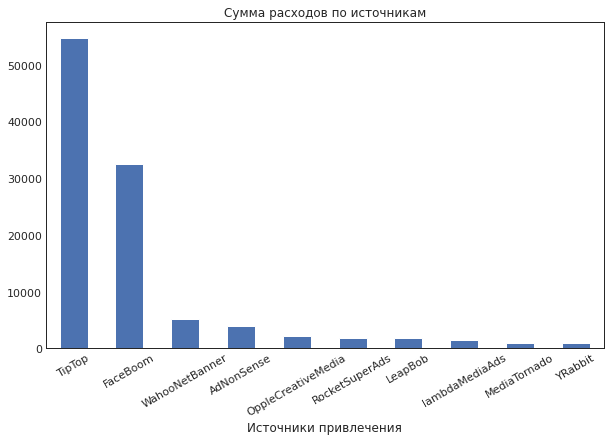

Таблица расходов по источникам


,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [28]:
# Делаем расчет расходов по источникам
channel_costs = costs.pivot_table(index='channel',
                  values='costs',
                  aggfunc='sum'). sort_values(by='costs', ascending=False)
channel_costs.plot(kind= 'bar', legend= '', figsize= (10, 6))
plt.xticks(rotation=30)
plt.xlabel('Источники привлечения')
plt.title('Сумма расходов по источникам')
plt.show()
print('Таблица расходов по источникам')
channel_costs

По данным видно, что больше всего было привлечено на такие плащадки как TipTop и FaceBoom. Который по сумме привлечения сильно отрываются от других компаний.

### Распределение трат на привлечение по времени

Для начала определим как увеличивалась общас сумма трат на маркетинг по времени:

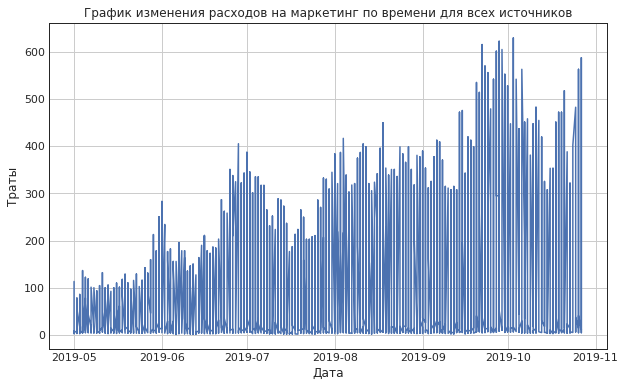

In [29]:
# Построим график изменений расходов на маркетинг
costs.plot(y='costs',
           x='dt',
           figsize=(10, 6),
           grid=True,                     
           legend='') 

plt.title('График изменения расходов на маркетинг по времени для всех источников')
plt.xlabel('Дата')
plt.ylabel('Траты')
plt.xticks(rotation=0)
plt.show()

Как мы видим, общая сумма затрат на маркетинг со временем растет. Существенный рост затрат пришелся на октябрь 2019 года.

Далее посмотрим как менялись затраты на маркетинг в зависимости от площадки:

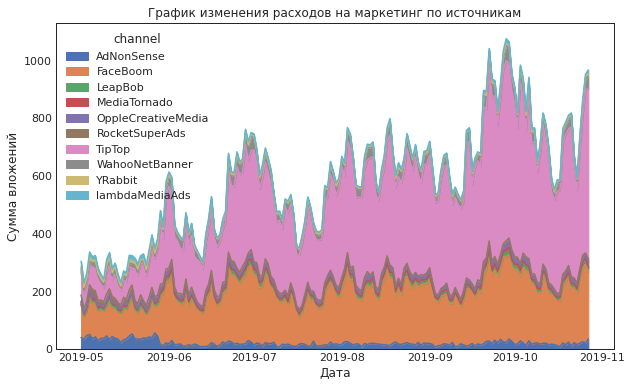

In [30]:
channel_costs = costs.pivot_table(index='dt',
                                  values='costs',
                                  columns='channel',
                                  aggfunc='sum')

channel_costs.plot.area(figsize= (10, 6),
                   label='Каналы')
plt.xlabel('Дата')
plt.ylabel('Сумма вложений')
plt.title('График изменения расходов на маркетинг по источникам')
plt.show()

In [31]:
# Добавим столбцы с указанием номера недели и месяца
costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week
costs['month'] = costs['dt'].dt.month

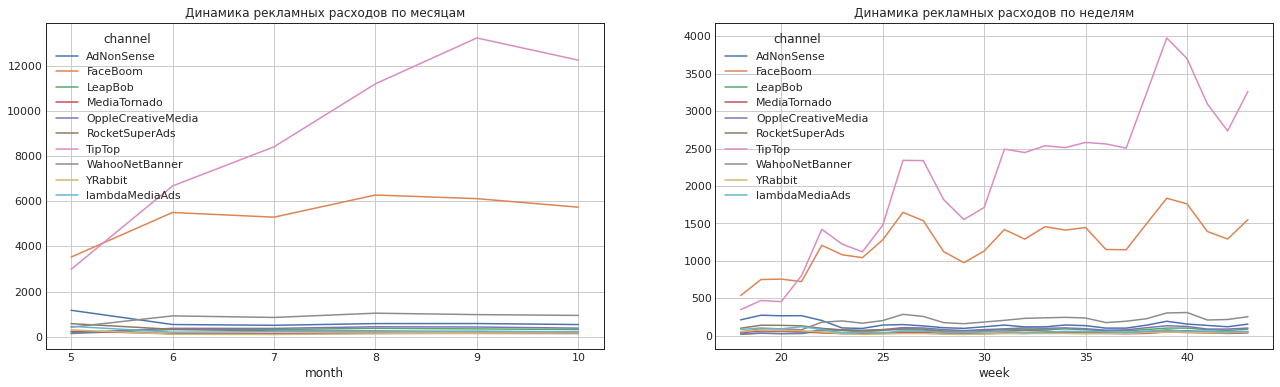

In [32]:
# Строим график динамики распределения рекламных расходов 
plt.figure(figsize=(22,6))
costs.pivot_table(index='month',
                  columns='channel',
                  values='costs',
                  aggfunc='sum').plot(grid=True, ax=plt.subplot(1,2,1));
plt.title('Динамика рекламных расходов по месяцам')

costs.pivot_table(index='week',
                  columns='channel',
                  values='costs',
                  aggfunc='sum').plot(grid=True, ax=plt.subplot(1,2,2));
plt.title('Динамика рекламных расходов по неделям');

По графику видно, что больше всего средств тратилось на TipTop и FaceBoom, причем если в самом начале были примерно одинаковые затраты, то после июля 2019 года произошёл существенный рост затрат на TipTop. Скорее всего это связано с популярнойстью площадки.

Хотелось бы еще посмотреть графики распределения без двух фаворитов:

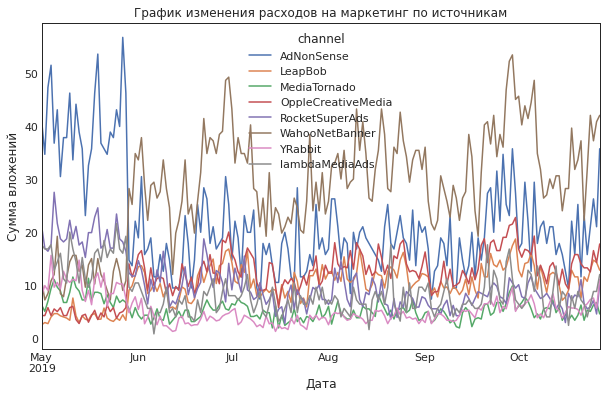

In [33]:
channel_costs = costs.query('channel != ["TipTop", "FaceBoom"]').pivot_table(index='dt',
                                  values='costs',
                                  columns='channel',
                                  aggfunc='sum')

channel_costs.plot(figsize= (10, 6),
                   label='Каналы')
plt.xlabel('Дата')
plt.ylabel('Сумма вложений')
plt.title('График изменения расходов на маркетинг по источникам')
plt.show()

Как мы видим, небольшой отрыв есть у WahooNetBanner. Остальные источники имеют более менее одинаковые расходы на маркетинг.

### Анализ стоимости привлечения пользователя

Нам необходимо провести анализ стоимости привлечения одного пользователя (CAC)

Для начала посмотрим сколько в среднем стоит привлечь пользователей для всех источников:

In [34]:
profiles['acquisition_cost'].describe()

count   150008.00
mean         0.70
std          0.95
min          0.00
25%          0.00
50%          0.25
75%          1.11
max          3.72
Name: acquisition_cost, dtype: float64

Как мы видим, в среднем для привлечения пользователя затрачивают 0.7 у.е. Максимальные затраты были 3.72. Для медианного значения этот параметр будет 0.25 у.е.  

In [35]:
profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)

channel
TipTop               2.80
FaceBoom             1.11
AdNonSense           1.01
lambdaMediaAds       0.72
WahooNetBanner       0.60
RocketSuperAds       0.41
OppleCreativeMedia   0.25
YRabbit              0.22
MediaTornado         0.22
LeapBob              0.21
organic              0.00
Name: acquisition_cost, dtype: float64

Если смотреть по каналам привлечения, то дорожего всего стоит привлечь пользователя в TipTop 2.8 у.е., а дешевое всего в LeapBob - 0.21 у.е. Пользователи с органическим переходом вообще не требуют затрат на привлечение. 

### Выводы по главе

По результатам маркетинговых исследований выявили:

- Всего на маркетинг было потрачено 105497.3 у.е., причем, эта самма расла на протяжении всего периода наблюдения. 
- Больше всего маркетинговых затрат приходится на TipTop - около 51.9%, далее идет FaceBoom - 30.75%. Также выявили, что для органического привлечения не требуется затрат. 
- Посмотрели как распределяются затраты на маркетинг по времени для каждого источника. 
- Была вычислена стоимость привлечения одного пользователя (CAC), в среднем на привлечение пользователя тратится 0.7 у.е., а если смотрить по источникам, то дороже всего привлекать клиентов в TipTop, где затрата на привлечение клиента достигает 2.8 у.е. Дешевле же всего привлекать органических пользователей, поскольку они не требуют затрат на привлечение. 

## Рекламные метрики

С использованием графиков LTV, ROI и CAC, проанализируем окупаемость рекламы. Для расчетов представим, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Для расчета рекламных метрик исследуем следующие параметры:

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

При написании выводов, нужно ответить на такие вопросы:

- Окупается ли реклама, направленная на привлечение пользователей в целом?
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

### Анализ окупаемости рекламы с помощью LTV и ROI

In [36]:
# Исключаем органических пользователей
profiles = profiles.query('channel != "organic"')

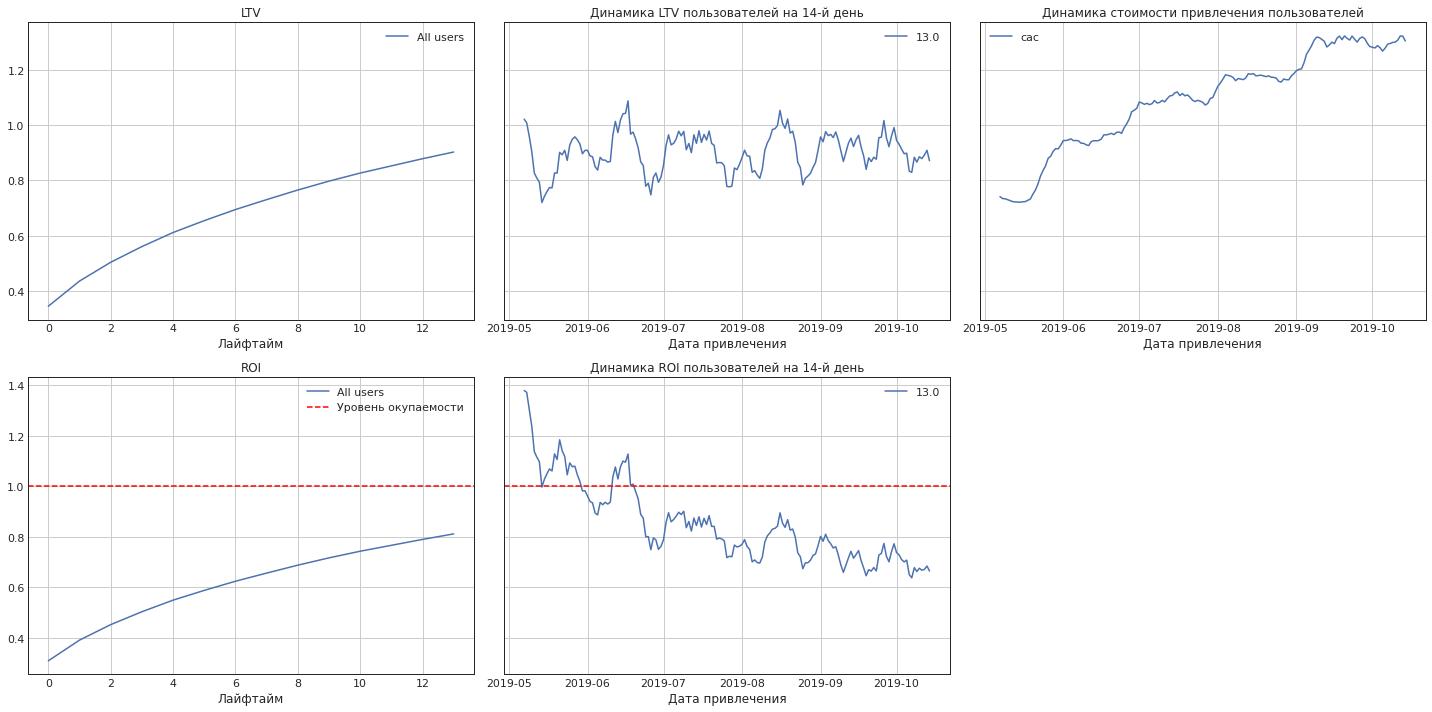

In [37]:
# проанализируем общую окупаемость рекламы, считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По полученным данным видно, что:

1. ROI к концу второй недели достигает чуть более 80%. А значит, реклама не окупается. 
2. LTV растет с течением времени, как и должно быть по свойствам. Динамика LTV имеет цикличные изменения, но находится на стабильном уровне 
3. Стоимость привлечения клиентов со временем растет.

### Анализ окупаемости рекламы по устройствам

Исследуем данные окупаемости рекламы в зависимости от типа устройств

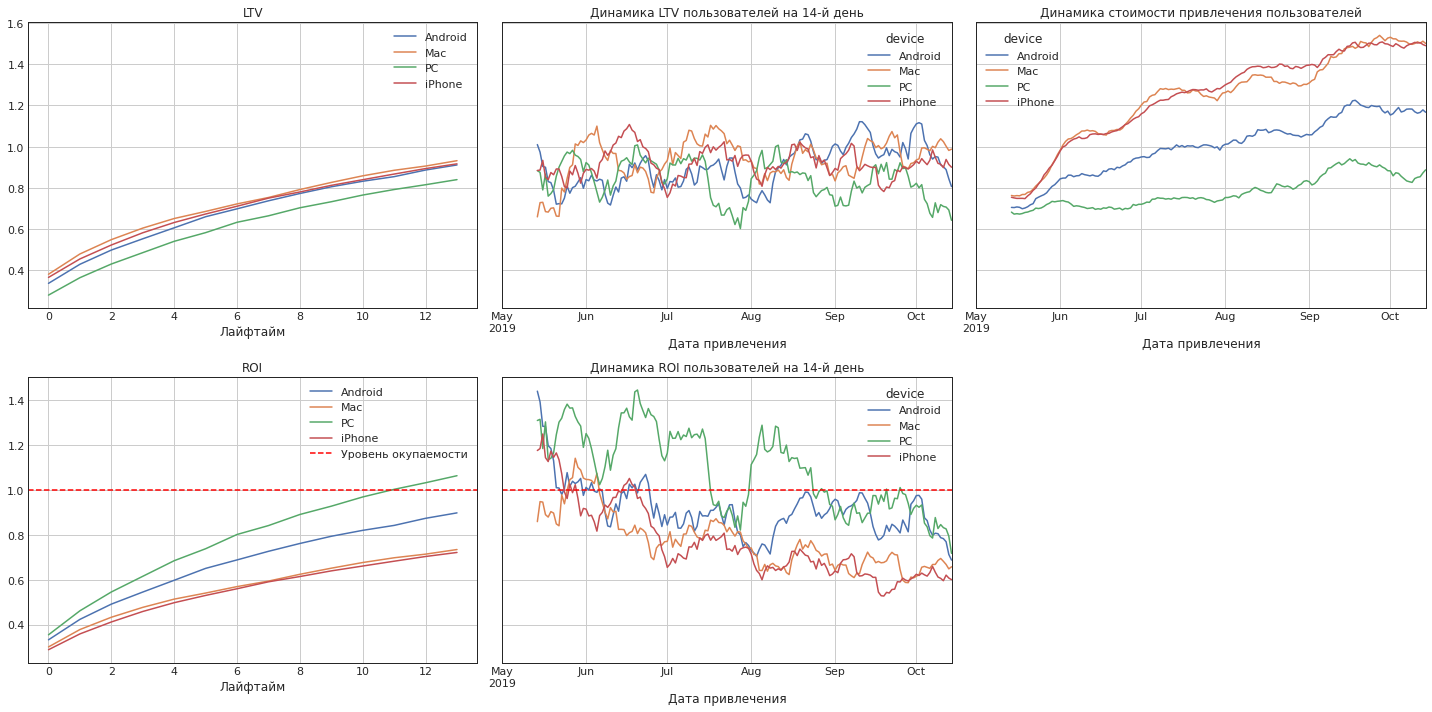

In [38]:
# Смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам видно, что чаще всего платящие пользователи заходят с iPhone, Mac и Android, а меньше всего с PC. 
Динамика LTV со временем сохраняется. А вот стоимость привлечения клиентов для iPhone и Mac со временем сильно выросла по сравнению с другими устройствами. Это обуславливает то, что рекламная компания для пользователей iPhone и Mac со временем не окупилась. 

Чтобы понять почему реклама для этих устройств не окупилась посмотрим параметри конверсии:

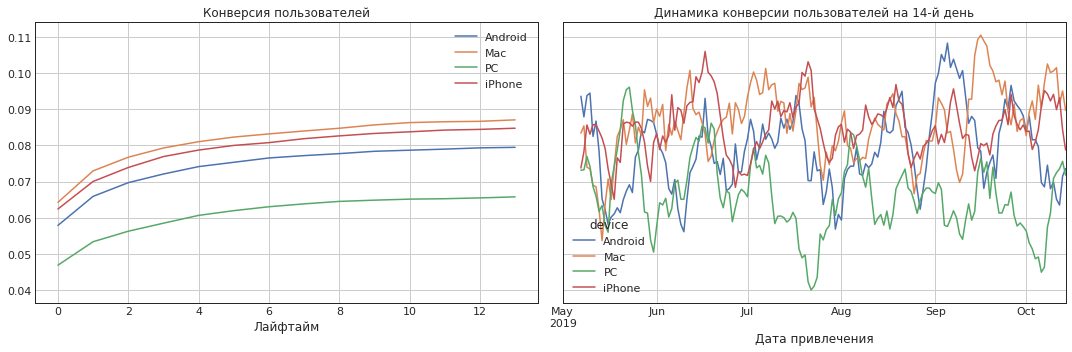

In [39]:
# Посчитаем и визуализируем конверсию по различным устройстам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Как мы видим, пользователи с устройств iPhone и Mac хорошо конверсируют, более того, данная динамика хорошо сохраняется со временем. 

Вполне возможно, что все дело в удержании клиентов, посмотрим параметры удержания:

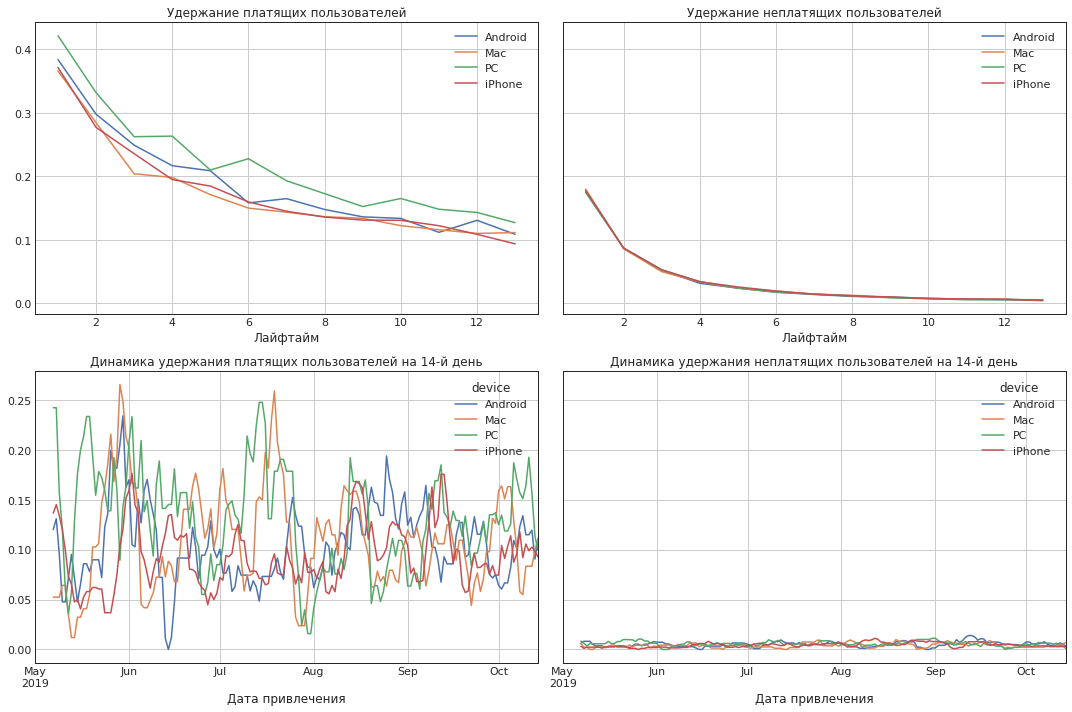

In [40]:
# Смотрим удержание с разбивкой по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графика видно, что удержание пользователей происходит равномерно для всех устройств. 

### Анализ окупаемости рекламы по странам

Посмотрим как меняются рекламные метрики в зависимости от стран:

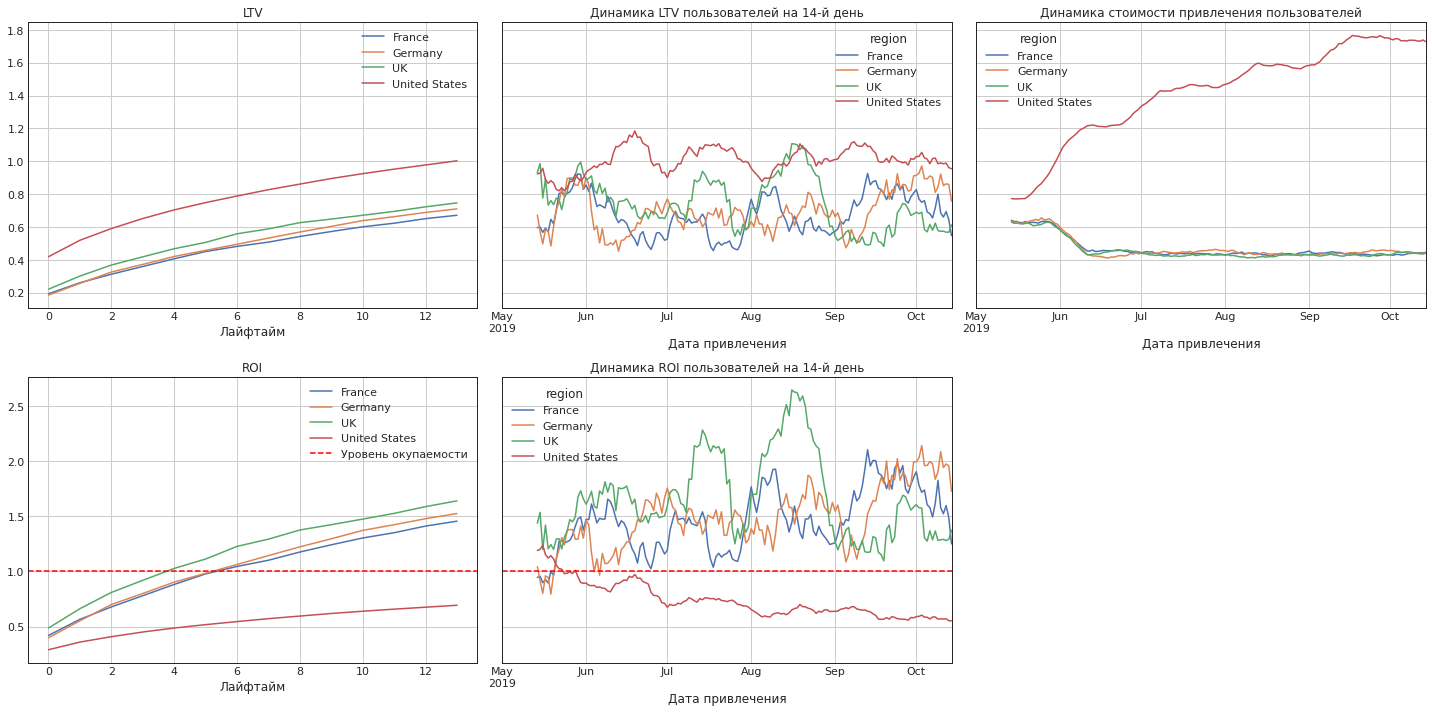

In [41]:
# Смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам видно, что реклама в US не окупается. Более того, эта динамика со временем ухудшается. Это все происходит из за того, что со временем растет стоимость привлечения пользователей. Для других же стран все параметры более-менее одинаковые. 

Посмотри конверсию для пользователей в различных странах:

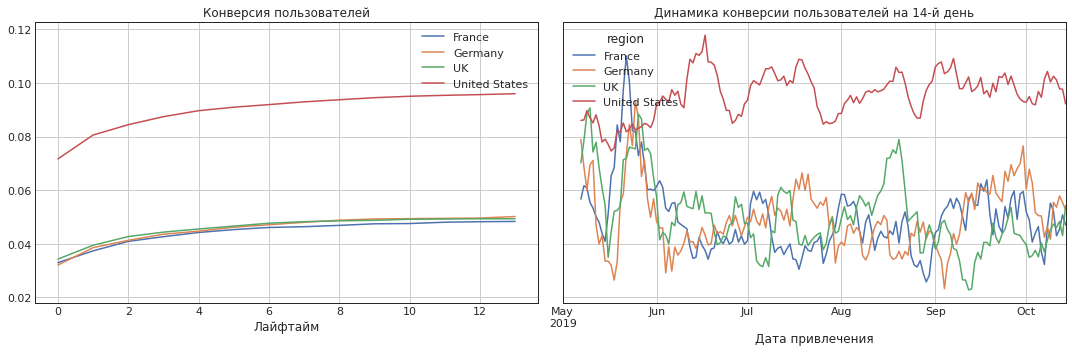

In [42]:
# Посчитаем конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия у пользователей из US явно выше остальных, эта динамика сохраняется со временем. 

Посмотри параметры удержания пользователей в различных странах: 

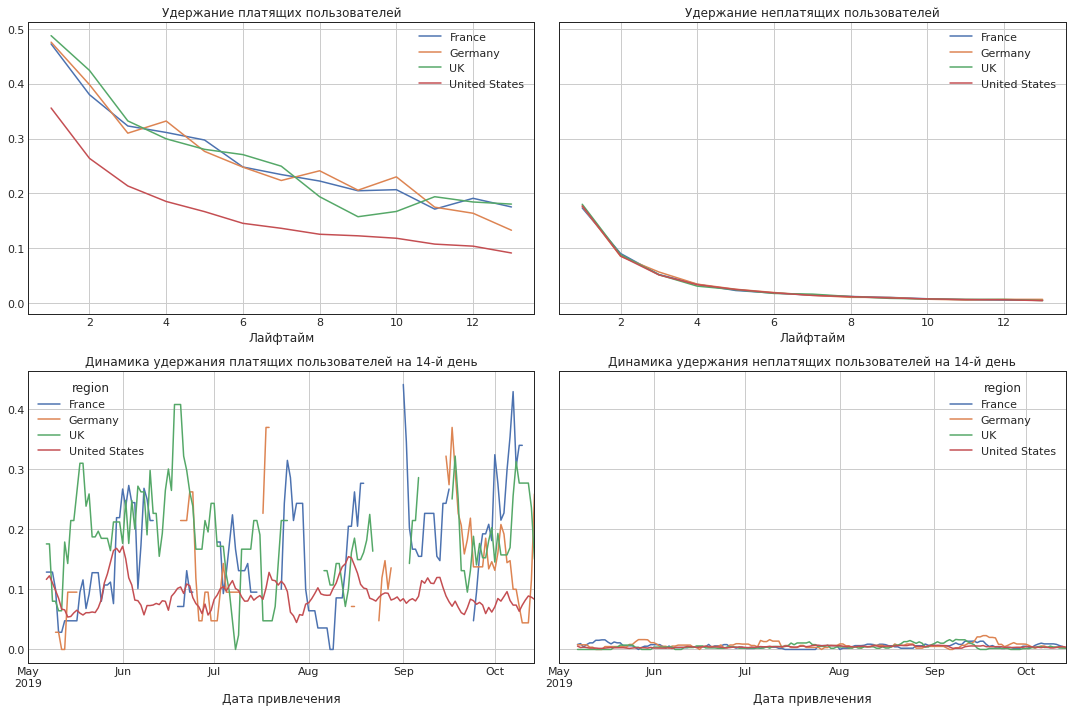

In [43]:
# Смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Вот и выяснилась причина, почему реклама у пользователей из US не окупается, все дело в том, что данные платные пользователи плохо удерживаеются. 

### Анализ окупаемости рекламы по источникам привлечения

Посмотри метрики окупаемости рекламы в зависимости от источников привлечения:

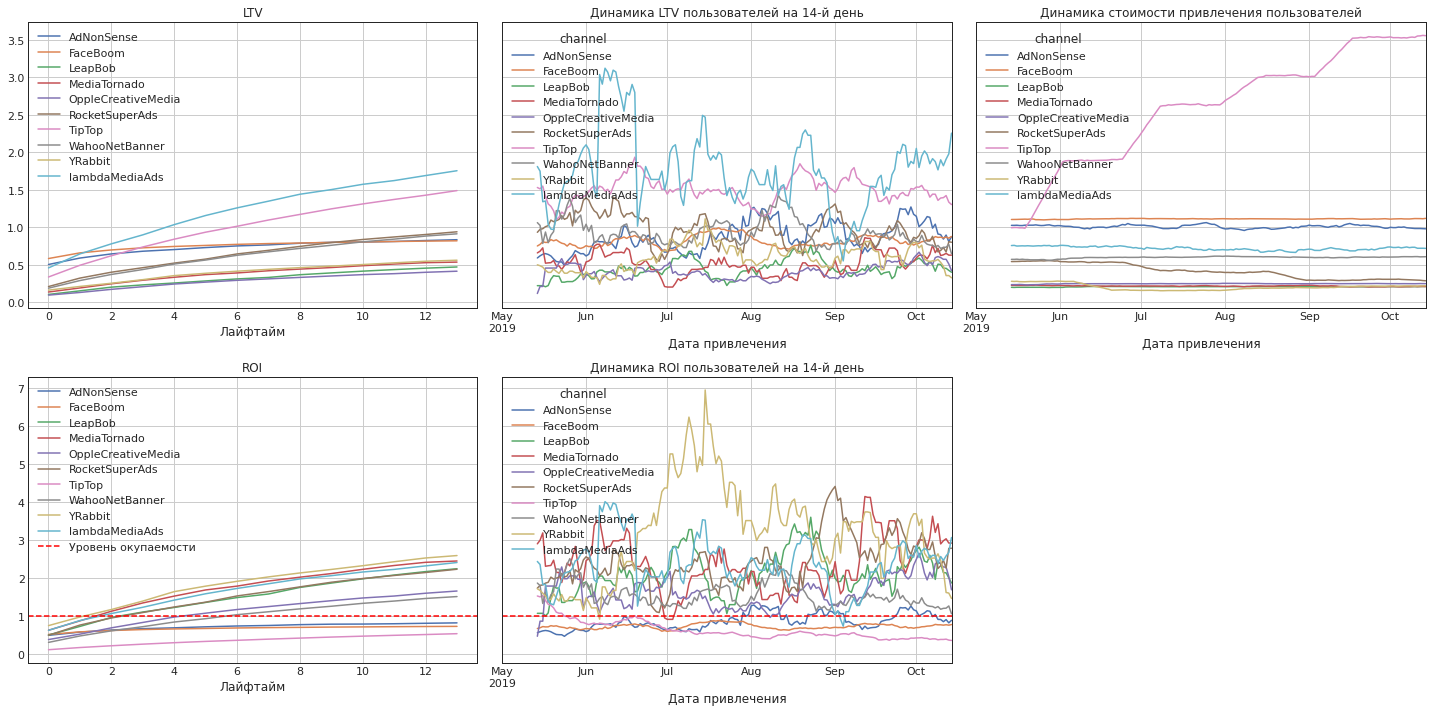

In [44]:
# Проверим источники привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам видно, что некоторые истончики привлечения со временем не окупаются, например TipTop, у которого стоимость привлечения клиентов со временем очень сильно выросла. Также, динамика для пользователей с площадок TipTop и FaceBoom говорит о том, что они не будут окупаться со временем. 

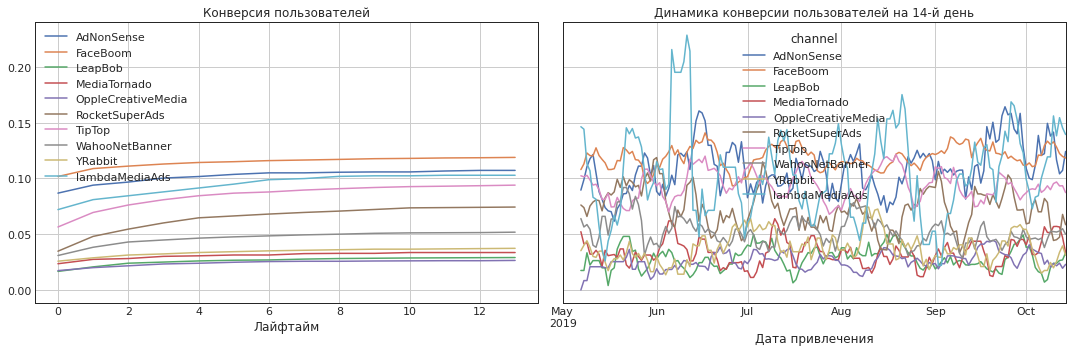

In [45]:
# Смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

По графикам конверсии видно, что наибольшей конверсией обладают пользователи с площадки FaceBoom. Если смотреть по динамике, то площадки TipTop и FaceBoom здесь будут в числе лидеров. 

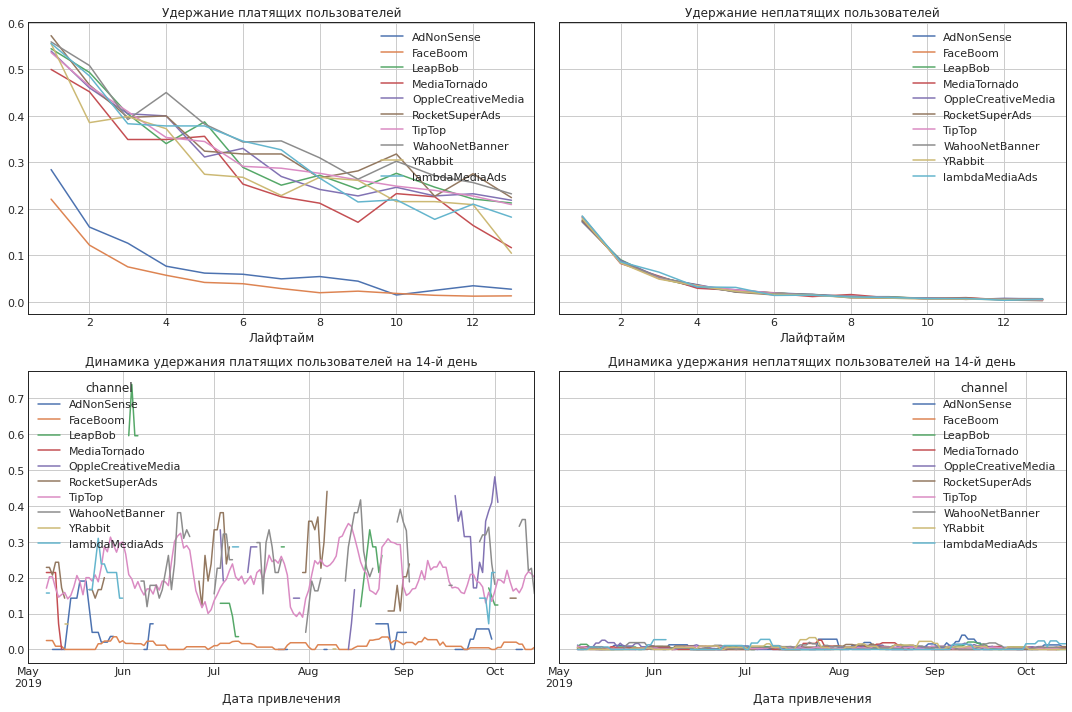

In [46]:
# Смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Как мы видим, пользователи FaceBoom и AdNonSense очень плохо удерживаются, а вот остальные пользователи задерживаются на дольше.

### Выводы по главе

Кратие выводы по главе:

- Мы увидели, что реклама со временем окупается. 
- ROI в среднем для всех пользователей чуть более 80%. 
- Мы определили, что пользователей iPhone и Mac со временем тяжелее удержать.
- Наиболее затратными для привлечения являются пользователи TipTop и FaceBoom. 
- FaceBoom со временем не окупается и этих пользователей труднее удержать.

## Общий вывод

В ходе выполнения работы была выполнена предварительная обработка данных:

- Необходимы столбцы приведены к нужному формату данных;
- Необходимые данные приведены к нужному регистру;
- Заменены некоторые названия столбцов на нужные;
- Выполнена проверка данных на наличие полных дубликатов и пропусков.

Были написаны вспомогательные функции для расчета необходимых метрик. 

Далее были определены пользовательские профили, определены даты начала (1 мая 2019 года) и конца (27 октября 2019 года) наблюдений. Определён горизонт наблюдений, равный 14 дням. 

В хоте исследовательского анализа было определено: 

1. Колличество пользователей по странам:
- Больше всего пользователей в US 100002, при этом колличество платных пользователей 6902, т.е. конверсия будет 6.9%
- Меньше всего пользователей в Германии 14981, при этом колличество платных пользователей 616
- Конверсия у пользователей из UK и Франции примерно одинакова и составляет 3.98% и 3.8% соответственно.

2. Колличество пользователей по устройствам:
- Больше всего пользователей на iPhone 51097, при этом колличество платных пользователей 3382
- Меньше всего пользователей на Mac 30042, при 1912 платных пользователей
- Самые большие конверсии у пользователей Mac (6.36%) и iPhone (6.21%), самая маленькая конверсия у пользователей PC (5.05%)

3. Колличество пользователей по каналам привлечения: 
- Больше всего приходит органических пользователей 56439, однако они обладают меньшей конверсией 2.06%
- Самые большие конверсии у FaceBoom - 12.2%, AdNonSense - 11.34% и lambdaMediaAds 10.47%

В ходе маркетинговых исследований было выявлено:

1. Общая сумма затрат на маркетинг составила 105497.3 у.е.
2. По колличеству затрат на рекламу с большим отрывом лидируют TipTop 54751.3 и FaceBoom 32445.6
3. Со временем сумма инвестиций в маркетинг растет. 
4. Среди фаворитов по затратам TipTop и FaceBoom тоже виден норм со временем. 
5. Самые большие затраты на привлечение у пользователей TipTop 2.8 на единицу, далее идут FaceBoom 1.11 и AdNonSense 1.01. На привлечение органических пользователей затрат нет. 

В ходе анализа рекламных общих метрик было определено:

1. По прошествию 14 дней реклама для большенства пользователей не окупается. 
2. Динамика LTV положительно циклична.
3. Со временем сильно растут затраты на привлечение клиентов. 

Если смотреть метрики по устройствам, то видно, что чаще всего пользователи заходят с iPhone, Mac и Android, а меньше всего с PC. 
Динамика LTV со временем сохраняется. А вот стоимость привлечения клиентов для iPhone и Mac со временем сильно выросла по сравнению с другими устройствами. Это обуславливает то, что рекламная компания для пользователей iPhone и Mac со временем не окупилась. 

По анализу окупаемости рекламы по странам видно, что реклама в US не окупается. Более того, эта динамика со временем ухудшается. Это все происходит из за того, что со временем растет стоимость привлечения пользователей. Для других же стран все параметры более-менее одинаковые. Конверсия у пользователей из US явно выше остальных, однако, пользователи из US очень плохо удерживаются.

Если смотреть анализ по каналам привлечения, то видно, что некоторые истончики привлечения со временем не окупаются, например TipTop, у которого стоимость привлечения клиентов со временем очень сильно выросла. Также, динамика для пользователей с площадок TipTop и FaceBoom говорит о том, что они не будут окупаться со временем. Наибольшей конверсией обладают пользователи с площадки FaceBoom. Если смотреть по динамике, то площадки TipTop и FaceBoom здесь будут в числе лидеров. Пользователи FaceBoom и AdNonSense очень плохо удерживаются, а вот остальные пользователи задерживаются на дольше.



### Рекомендации для отдела маркетинга

Сделать ставку на рекламную компанию в TipTop, несмотря на то, что расходы на привлечение клиентов тут самые выскоие, но и реклама за 14 дней почти окупается, а также удержание клиентов намного выше чем у аналогичного FaceBoom, который мало того что не окупается, но и со временем теряет больше всего клиентов. 

Помимо этого необходимо увеличить долю пользователей AdNonSense и lambdaMediaAds, поскольку у этих каналов высокая конверсия. 

Если увеличить конверсию у органических пользователей, то это сильно сократит расходы на рекламу в дальнейшем, поскольку привлечение данных пользователей бесплатно, а со временем они хорошо удерживаются. 

Можно дополнительно привлекать пользователей из Германии, у которых высокая конверсия. При этом сокращать колличество инвестиций в рекламу в US, поскольку там слишком большая стоимость привлечения клиентов и последующее их удержание, при этом данные пользователи почти не окупаются. 